# Speed Test Results analysis

A look at the results of an hourly speedtest.net result from my raspi. I't unlikely that these reflect the best speed available, due to limitations of the pi ehternet interface, but they may be useful for looking at the worst

In [1]:
import sys, os,string,time,random,math
import tarfile, zipfile

import numpy as np
import pandas as pd
import pickle

from PIL import Image

from matplotlib import pyplot as plt
from IPython.display import display, Image
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import TensorBoard

from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats


Using TensorFlow backend.


In [2]:
#open a CSV as a dataframe

def loadData(filename,datadir='./'):
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # write the data as a CSV
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [3]:
filename='speedtest_results.csv'
data=loadData(filename).dropna() #read data and drop empty
data.Timestamp=pd.to_datetime(data.Timestamp)
#data.Timestamp=data.Timestamp.interpolate(method='time')
#data.Ping=data.Ping.interpolate()
data.index=data.Timestamp
data.drop('Timestamp',axis=1,inplace=True)
#display(data[data.Upload.isnull()==True]) # show empty if we decide to not drop themm
display(data.info())
#display(data.head(5))
display(data.sample(5))
#display(data.tail(5))
#display(data['2017'].tail(3))


loading: ./speedtest_results.csv
Dataset has 10627 samples with 8 features each.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10327 entries, 2017-08-16 16:40:01.806581 to 2018-01-15 15:00:10.511230
Data columns (total 7 columns):
Server ID      10327 non-null object
Sponsor        10327 non-null object
Server Name    10327 non-null object
Distance       10327 non-null float64
Ping           10327 non-null float64
Download       10327 non-null float64
Upload         10327 non-null float64
dtypes: float64(4), object(3)
memory usage: 645.4+ KB


None

,Server ID,Sponsor,Server Name,Distance,Ping,Download,Upload
Timestamp,,,,,,,
2017-09-27 05:00:02.097717,5024,AT&T,"Austin, TX",29.786789,44.803,6.233852e+07,1.899709e+07
2017-08-31 08:20:01.570701,6000,Time Warner Cable,"Austin, TX",30.617391,28.689,8.889475e+07,2.199179e+07
2017-09-04 23:20:07.749248,6000,Time Warner Cable,"Austin, TX",30.617391,24.311,8.736548e+07,1.958187e+07
2018-01-14 22:20:01.598119,6000,Time Warner Cable,"Austin, TX",30.767564,31.222,9.006393e+07,2.269143e+07
2017-12-22 00:20:02.035897,6000,Time Warner Cable,"Austin, TX",30.767564,27.471,6.673640e+07,2.194330e+07


In [4]:
print('Max Download: {:.4} Mbps'.format(float(data.Download.max())/1024.0/1024.0))
print('Min Download: {:.4} Mbps'.format(float(data.Download.min())/1024.0/1024.0))
print('Avg Download: {:.4} Mbps'.format(float(data.Download.mean())/1024.0/1024.0))
print('')

print('Max Upload: {:.4} Mbps'.format(data.Upload.max()/1024/1024 ))
print('Min Upload: {:.4} Mbps'.format(data.Upload.min()/1024/1024 ))
print('Avg Upload: {:.4} Mbps'.format(data.Upload.mean()/1024/1024 ))

print('')
print('Max Ping(latency): {:.4}ms'.format(data.Ping.max()))
print('Min Ping(latency): {:.4}ms'.format(data.Ping.min()))
print('avg Ping(latency): {:.4}ms'.format(data.Ping.mean()))
print('')
display('Server Names:',data.groupby('Server Name').count())
display('Server IDs',data.groupby('Server ID').count())
display('Avg Ping:',data.groupby('Server ID').Ping.mean()  )
display('Avg Upload:',data.groupby('Server ID').Upload.mean()/1024/1024 )
display('Avg Download:',data.groupby('Server ID').Download.mean()/1024/1024 )


Max Download: 89.67 Mbps
Min Download: 1.461 Mbps
Avg Download: 81.24 Mbps

Max Upload: 22.37 Mbps
Min Upload: 3.413 Mbps
Avg Upload: 19.63 Mbps

Max Ping(latency): 220.0ms
Min Ping(latency): 18.0ms
avg Ping(latency): 30.11ms



'Server Names:'

,Server ID,Sponsor,Distance,Ping,Download,Upload
Server Name,,,,,,
"Austin, TX",10096,10096,10096,10096,10096,10096
"San Marcos, TX",231,231,231,231,231,231


'Server IDs'

,Sponsor,Server Name,Distance,Ping,Download,Upload
Server ID,,,,,,
11208,327,327,327,327,327,327
4323,231,231,231,231,231,231
5024,473,473,473,473,473,473
5368,537,537,537,537,537,537
6000,7986,7986,7986,7986,7986,7986
7189,773,773,773,773,773,773


'Avg Ping:'

Server ID
11208    36.392287
4323     43.213965
5024     39.690579
5368     40.474194
6000     27.340361
7189     39.089687
Name: Ping, dtype: float64

'Avg Upload:'

Server ID
11208    20.655070
4323     20.196838
5024     20.479833
5368     20.554766
6000     19.533421
7189     18.832887
Name: Upload, dtype: float64

'Avg Download:'

Server ID
11208    83.282879
4323     68.544933
5024     74.482124
5368     77.336777
6000     83.723369
7189     65.355024
Name: Download, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called drop(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
.resample() is now a deferred operation
You called drop(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  import sys


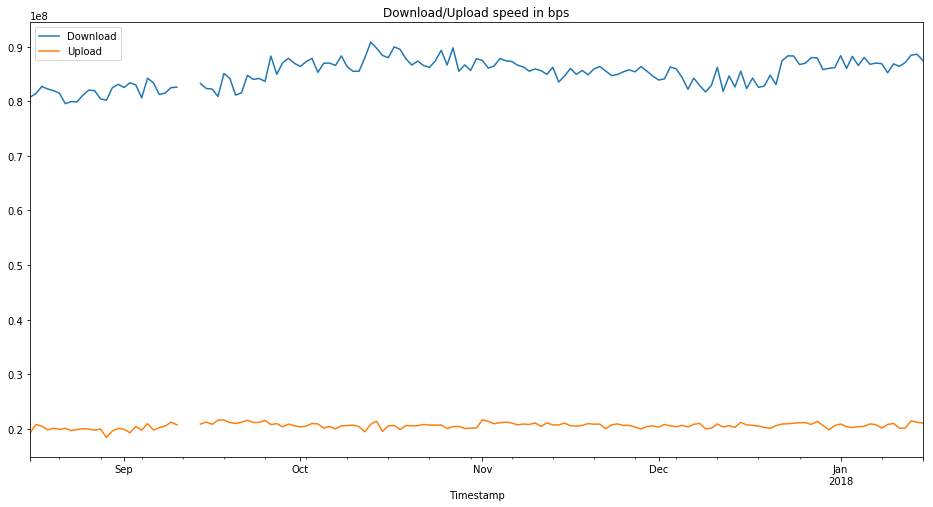

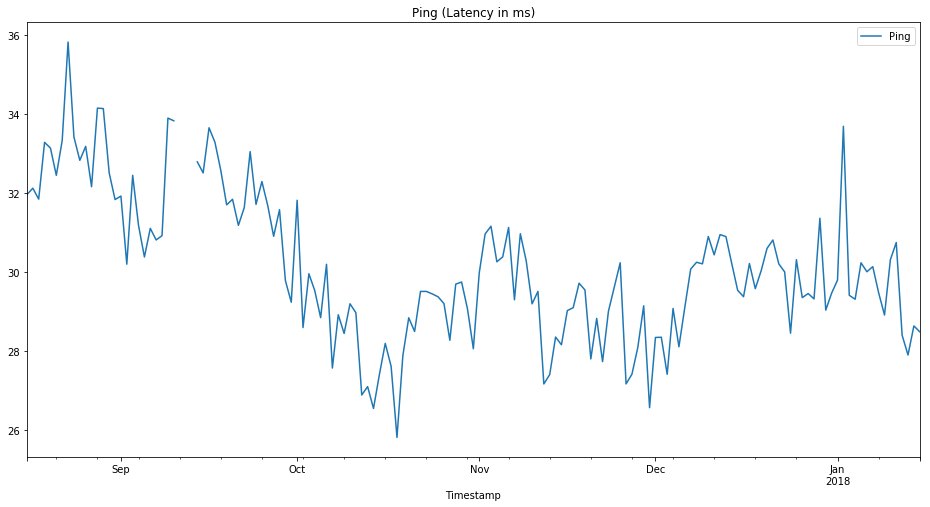

In [5]:
sample_rate='d' #h=hour,d=Day,m=month
#data.plot()
#data.drop(['Distance','Ping'],axis=1).plot(figsize=(16,8),title='Download/Upload speed in bps')
data.resample(sample_rate).drop(['Distance','Ping'],axis=1).plot(figsize=(16,8),title='Download/Upload speed in bps')

#data.drop(['Distance','Download','Upload'],axis=1).plot(figsize=(16,8),title='Ping (Latency in ms)')
data.resample(sample_rate).drop(['Distance','Download','Upload'],axis=1).plot(figsize=(16,8),title='Ping (Latency in ms)')

In [6]:
win_size=100
resample_period='h'

#samp_period_vs_win_size={'d':20,'h':120,'unchanged':120}

# transforms the input series 
# and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []

    for window in range(len(series)-window_size):
        X.append(series[window:window+window_size])
        y.append(series[window+window_size])
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

# pick one: first resamples to selected time frame, second uses all data
#data_series=data.resample(resample_period).Ping.mean()[1:].fillna(data.Ping.mean()) #resample to hourly
data_series=data.Ping[4:].copy()  #skip some bad initial data
#remove outliers in the data
data_series_outliers_removed=data_series[(np.abs(stats.zscore(data_series)) < 5)]
#convert to a numpy array
data_ready_for_scaling=np.array(data_series_outliers_removed).reshape(-1, 1)
data_ready_for_scaling=np.array(data_series).reshape(-1, 1)

#scale data appropriatly
#scaler=MinMaxScaler(feature_range=(-1, 1))
scaler=RobustScaler()
data_series_scaled=scaler.fit_transform(data_ready_for_scaling)
#use PCA
pca=PCA(n_components=1)
PCA_data_series_scaled=pca.fit_transform(data_series_scaled)

#verify the amount of data in use
display(len(data_series_scaled))

#setup X and y
X,y=window_transform_series(series=data_series_scaled, window_size=win_size)
#verify that X and Y came out correctly.
print(X[1][-1])
print(y[0])


10323

0.20119760479
[ 0.2011976]


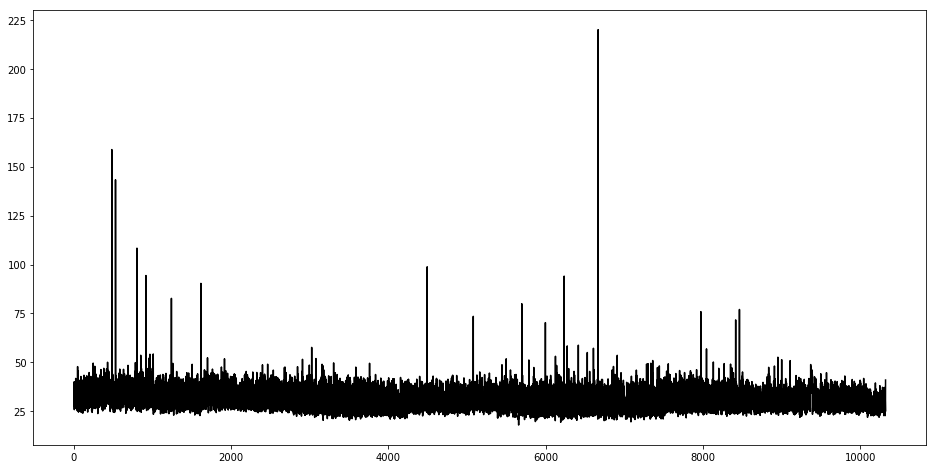

In [7]:
plt.figure(figsize = (16,8))
# plot original series
plt.plot(scaler.inverse_transform(data_series_scaled),color = 'k')



In [8]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], win_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], win_size, 1)))

In [9]:
def build_model(window_size):
    model=Sequential()
    model.add(LSTM(100, input_shape = (window_size,1),  dropout=.4))
    model.add(Dense(1))
    return model

model=build_model(win_size)
display(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


None

In [12]:
#callbacks
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.Adam(lr=0.001)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [52]:
# run your model!
model_history=model.fit(X_train, y_train, epochs=1700, batch_size=150, verbose=2)

Epoch 1/1700
19s - loss: 0.7312
Epoch 2/1700
20s - loss: 0.7214
Epoch 3/1700
21s - loss: 0.7178
Epoch 4/1700
20s - loss: 0.7170
Epoch 5/1700
20s - loss: 0.7154
Epoch 6/1700
21s - loss: 0.7072
Epoch 7/1700
20s - loss: 0.7060
Epoch 8/1700
20s - loss: 0.7083
Epoch 9/1700
21s - loss: 0.7011
Epoch 10/1700
20s - loss: 0.7020
Epoch 11/1700
20s - loss: 0.7005
Epoch 12/1700
21s - loss: 0.7035
Epoch 13/1700
20s - loss: 0.7025
Epoch 14/1700
21s - loss: 0.7019
Epoch 15/1700
21s - loss: 0.6990
Epoch 16/1700
20s - loss: 0.6962
Epoch 17/1700
21s - loss: 0.6972
Epoch 18/1700
21s - loss: 0.6960
Epoch 19/1700
21s - loss: 0.6953
Epoch 20/1700
21s - loss: 0.6921
Epoch 21/1700
20s - loss: 0.6827
Epoch 22/1700
20s - loss: 0.6947
Epoch 23/1700
21s - loss: 0.7138
Epoch 24/1700
20s - loss: 0.7138
Epoch 25/1700
21s - loss: 0.7033
Epoch 26/1700
21s - loss: 0.7029
Epoch 27/1700
20s - loss: 0.6853
Epoch 28/1700
20s - loss: 0.6744
Epoch 29/1700
21s - loss: 0.6623
Epoch 30/1700
20s - loss: 0.6560
Epoch 31/1700
21s -

21s - loss: 0.6474
Epoch 246/1700
21s - loss: 0.6512
Epoch 247/1700
21s - loss: 0.6489
Epoch 248/1700
21s - loss: 0.6527
Epoch 249/1700
21s - loss: 0.6414
Epoch 250/1700
21s - loss: 0.6403
Epoch 251/1700
21s - loss: 0.6483
Epoch 252/1700
21s - loss: 0.6357
Epoch 253/1700
21s - loss: 0.6681
Epoch 254/1700
21s - loss: 0.6847
Epoch 255/1700
21s - loss: 0.6840
Epoch 256/1700
21s - loss: 0.6812
Epoch 257/1700
21s - loss: 0.6759
Epoch 258/1700
21s - loss: 0.6836
Epoch 259/1700
21s - loss: 0.6807
Epoch 260/1700
21s - loss: 0.6768
Epoch 261/1700
21s - loss: 0.6765
Epoch 262/1700
21s - loss: 0.6792
Epoch 263/1700
21s - loss: 0.6697
Epoch 264/1700
21s - loss: 0.6768
Epoch 265/1700
21s - loss: 0.6713
Epoch 266/1700
21s - loss: 0.6468
Epoch 267/1700
21s - loss: 0.6438
Epoch 268/1700
21s - loss: 0.6396
Epoch 269/1700
21s - loss: 0.6419
Epoch 270/1700
21s - loss: 0.6317
Epoch 271/1700
21s - loss: 0.6352
Epoch 272/1700
21s - loss: 0.6328
Epoch 273/1700
21s - loss: 0.6423
Epoch 274/1700
21s - loss: 0.

21s - loss: 0.6119
Epoch 487/1700
21s - loss: 0.6126
Epoch 488/1700
21s - loss: 0.6123
Epoch 489/1700
21s - loss: 0.6074
Epoch 490/1700
20s - loss: 0.6080
Epoch 491/1700
21s - loss: 0.6034
Epoch 492/1700
21s - loss: 0.6041
Epoch 493/1700
21s - loss: 0.6111
Epoch 494/1700
21s - loss: 0.6051
Epoch 495/1700
21s - loss: 0.6061
Epoch 496/1700
21s - loss: 0.6094
Epoch 497/1700
21s - loss: 0.6046
Epoch 498/1700
21s - loss: 0.6080
Epoch 499/1700
21s - loss: 0.6028
Epoch 500/1700
21s - loss: 0.6039
Epoch 501/1700
21s - loss: 0.6022
Epoch 502/1700
21s - loss: 0.6047
Epoch 503/1700
21s - loss: 0.6015
Epoch 504/1700
21s - loss: 0.6033
Epoch 505/1700
21s - loss: 0.6043
Epoch 506/1700
21s - loss: 0.6095
Epoch 507/1700
21s - loss: 0.6026
Epoch 508/1700
21s - loss: 0.6004
Epoch 509/1700
21s - loss: 0.6039
Epoch 510/1700
21s - loss: 0.6004
Epoch 511/1700
21s - loss: 0.6349
Epoch 512/1700
21s - loss: 0.6204
Epoch 513/1700
21s - loss: 0.6052
Epoch 514/1700
21s - loss: 0.5980
Epoch 515/1700
21s - loss: 0.

22s - loss: 0.5052
Epoch 728/1700
21s - loss: 0.5106
Epoch 729/1700
21s - loss: 0.5343
Epoch 730/1700
21s - loss: 0.5024
Epoch 731/1700
21s - loss: 0.5000
Epoch 732/1700
21s - loss: 0.5089
Epoch 733/1700
21s - loss: 0.4992
Epoch 734/1700
21s - loss: 0.4867
Epoch 735/1700
21s - loss: 0.4925
Epoch 736/1700
21s - loss: 0.5048
Epoch 737/1700
21s - loss: 0.5962
Epoch 738/1700
21s - loss: 0.5085
Epoch 739/1700
21s - loss: 0.5191
Epoch 740/1700
21s - loss: 0.5213
Epoch 741/1700
21s - loss: 0.5457
Epoch 742/1700
21s - loss: 0.4937
Epoch 743/1700
21s - loss: 0.5152
Epoch 744/1700
21s - loss: 0.4832
Epoch 745/1700
21s - loss: 0.5088
Epoch 746/1700
21s - loss: 0.4813
Epoch 747/1700
21s - loss: 0.4970
Epoch 748/1700
21s - loss: 0.4883
Epoch 749/1700
21s - loss: 0.4725
Epoch 750/1700
21s - loss: 0.5337
Epoch 751/1700
21s - loss: 0.4664
Epoch 752/1700
21s - loss: 0.5084
Epoch 753/1700
21s - loss: 0.4739
Epoch 754/1700
21s - loss: 0.4654
Epoch 755/1700
21s - loss: 0.4866
Epoch 756/1700
21s - loss: 0.

21s - loss: 0.4037
Epoch 969/1700
21s - loss: 0.4103
Epoch 970/1700
21s - loss: 0.3991
Epoch 971/1700
21s - loss: 0.4004
Epoch 972/1700
21s - loss: 0.4142
Epoch 973/1700
21s - loss: 0.4043
Epoch 974/1700
21s - loss: 0.4079
Epoch 975/1700
20s - loss: 0.4231
Epoch 976/1700
21s - loss: 0.4117
Epoch 977/1700
21s - loss: 0.3986
Epoch 978/1700
21s - loss: 0.3869
Epoch 979/1700
21s - loss: 0.3991
Epoch 980/1700
21s - loss: 0.3881
Epoch 981/1700
21s - loss: 0.3976
Epoch 982/1700
21s - loss: 0.3968
Epoch 983/1700
21s - loss: 0.3907
Epoch 984/1700
21s - loss: 0.3881
Epoch 985/1700
21s - loss: 0.3918
Epoch 986/1700
21s - loss: 0.3869
Epoch 987/1700
21s - loss: 0.5040
Epoch 988/1700
21s - loss: 0.4881
Epoch 989/1700
21s - loss: 0.4670
Epoch 990/1700
21s - loss: 0.4567
Epoch 991/1700
21s - loss: 0.4117
Epoch 992/1700
21s - loss: 0.4352
Epoch 993/1700
21s - loss: 0.4059
Epoch 994/1700
21s - loss: 0.3994
Epoch 995/1700
21s - loss: 0.3961
Epoch 996/1700
21s - loss: 0.4029
Epoch 997/1700
21s - loss: 0.

21s - loss: 0.2962
Epoch 1204/1700
21s - loss: 0.2839
Epoch 1205/1700
21s - loss: 0.2910
Epoch 1206/1700
21s - loss: 0.2941
Epoch 1207/1700
21s - loss: 0.2811
Epoch 1208/1700
21s - loss: 0.2875
Epoch 1209/1700
21s - loss: 0.2878
Epoch 1210/1700
21s - loss: 0.2763
Epoch 1211/1700
21s - loss: 0.2789
Epoch 1212/1700
21s - loss: 0.2745
Epoch 1213/1700
21s - loss: 0.2888
Epoch 1214/1700
21s - loss: 0.2882
Epoch 1215/1700
21s - loss: 0.2755
Epoch 1216/1700
21s - loss: 0.2786
Epoch 1217/1700
21s - loss: 0.2749
Epoch 1218/1700
21s - loss: 0.2726
Epoch 1219/1700
21s - loss: 0.2752
Epoch 1220/1700
21s - loss: 0.3201
Epoch 1221/1700
21s - loss: 0.2818
Epoch 1222/1700
21s - loss: 0.2738
Epoch 1223/1700
21s - loss: 0.2755
Epoch 1224/1700
21s - loss: 0.2742
Epoch 1225/1700
21s - loss: 0.2763
Epoch 1226/1700
21s - loss: 0.2856
Epoch 1227/1700
21s - loss: 0.2964
Epoch 1228/1700
21s - loss: 0.3005
Epoch 1229/1700
21s - loss: 0.2751
Epoch 1230/1700
21s - loss: 0.2661
Epoch 1231/1700
21s - loss: 0.3430
E

21s - loss: 0.2053
Epoch 1439/1700
21s - loss: 0.2264
Epoch 1440/1700
21s - loss: 0.1980
Epoch 1441/1700
21s - loss: 0.2017
Epoch 1442/1700
21s - loss: 0.2051
Epoch 1443/1700
21s - loss: 0.2026
Epoch 1444/1700
21s - loss: 0.2004
Epoch 1445/1700
21s - loss: 0.2084
Epoch 1446/1700
21s - loss: 0.2343
Epoch 1447/1700
21s - loss: 0.1941
Epoch 1448/1700
21s - loss: 0.2058
Epoch 1449/1700
21s - loss: 0.2116
Epoch 1450/1700
21s - loss: 0.2032
Epoch 1451/1700
21s - loss: 0.1931
Epoch 1452/1700
21s - loss: 0.1989
Epoch 1453/1700
21s - loss: 0.1996
Epoch 1454/1700
21s - loss: 0.2085
Epoch 1455/1700
21s - loss: 0.2022
Epoch 1456/1700
21s - loss: 0.2154
Epoch 1457/1700
21s - loss: 0.2204
Epoch 1458/1700
21s - loss: 0.2030
Epoch 1459/1700
21s - loss: 0.1996
Epoch 1460/1700
21s - loss: 0.2113
Epoch 1461/1700
21s - loss: 0.2038
Epoch 1462/1700
21s - loss: 0.2022
Epoch 1463/1700
21s - loss: 0.1971
Epoch 1464/1700
21s - loss: 0.2341
Epoch 1465/1700
21s - loss: 0.2941
Epoch 1466/1700
21s - loss: 0.2026
E

20s - loss: 0.1750
Epoch 1674/1700
20s - loss: 0.1707
Epoch 1675/1700
20s - loss: 0.1726
Epoch 1676/1700
20s - loss: 0.1746
Epoch 1677/1700
21s - loss: 0.1748
Epoch 1678/1700
20s - loss: 0.1833
Epoch 1679/1700
20s - loss: 0.1964
Epoch 1680/1700
20s - loss: 0.1801
Epoch 1681/1700
20s - loss: 0.1725
Epoch 1682/1700
20s - loss: 0.2099
Epoch 1683/1700
20s - loss: 0.1807
Epoch 1684/1700
20s - loss: 0.1831
Epoch 1685/1700
21s - loss: 0.1887
Epoch 1686/1700
20s - loss: 0.2317
Epoch 1687/1700
20s - loss: 0.2192
Epoch 1688/1700
20s - loss: 0.2624
Epoch 1689/1700
20s - loss: 0.1797
Epoch 1690/1700
20s - loss: 0.1684
Epoch 1691/1700
20s - loss: 0.1743
Epoch 1692/1700
21s - loss: 0.1748
Epoch 1693/1700
20s - loss: 0.1903
Epoch 1694/1700
20s - loss: 0.2001
Epoch 1695/1700
20s - loss: 0.1859
Epoch 1696/1700
20s - loss: 0.1873
Epoch 1697/1700
20s - loss: 0.1763
Epoch 1698/1700
20s - loss: 0.1705
Epoch 1699/1700
20s - loss: 0.1841
Epoch 1700/1700
21s - loss: 0.1700


In [13]:

model_history=model.fit(X_train, y_train, epochs=2, batch_size=150, verbose=2,callbacks=[tensorboard])

Epoch 1/2
32s - loss: 0.7283
Epoch 2/2
35s - loss: 0.7182


In [14]:
#save the weights and history to disk
with open('./trainHistoryDict', 'wb') as history_file:
    pickle.dump(model_history.history, history_file)
    print("saved model history to disk")
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model weights to disk")
    


saved model history to disk
Saved model weights to disk


In [15]:
# load from disk as test that save worked!
with open('./trainHistoryDict', 'rb') as history_file:
    model_history.history = pickle.load( history_file )
    print("loaded model history from disk")

# load weights into new model
model.load_weights("model.h5")
print("Loaded model weights from disk")

loaded model history from disk
Loaded model weights from disk


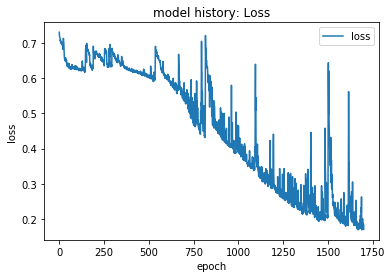

In [16]:

#added a visualization of the training
import matplotlib.pyplot as plt

plt.plot(model_history.history['loss'])
plt.title('model history: Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')

plt.show()

In [17]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [18]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.18379238832
testing error = 0.649394677948


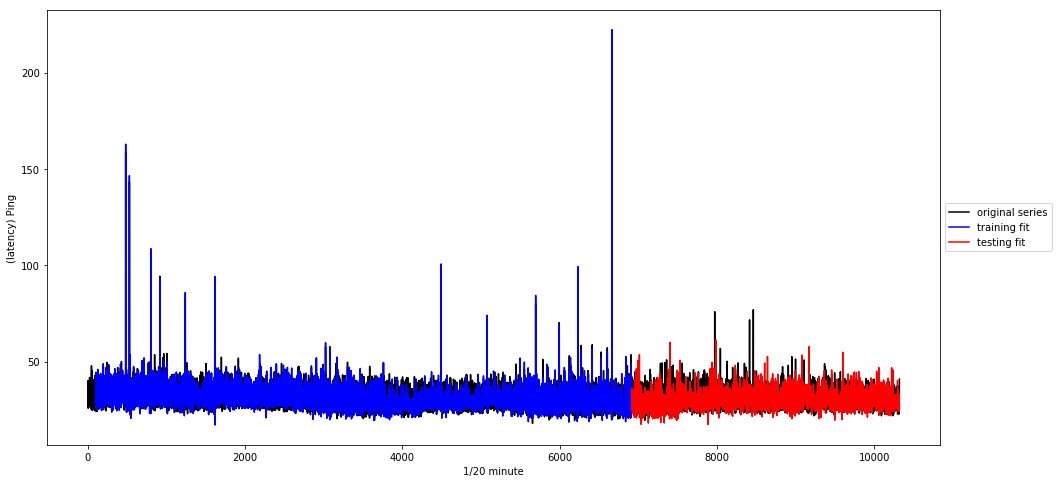

In [19]:
### Plot everything - the original series as well as predictions on training and testing sets

plt.figure(figsize = (16,8))
# plot original series
#plt.plot(scaler.inverse_transform(data_series_scaled),color = 'k')
plt.plot(data_ready_for_scaling,color = 'k')


# plot training set prediction
split_pt = train_test_split + win_size 
plt.plot(np.arange(win_size,split_pt,1),scaler.inverse_transform(train_predict),color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),scaler.inverse_transform(test_predict),color = 'r')

# pretty up graph
plt.xlabel('1/20 minute')
plt.ylabel('(latency) Ping')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:

print(len(data.Ping))
temp=np.zeros([1, len(data.Ping)-len(train_predict)-len(test_predict)] ).T
print(len(temp))
predicted_ping=np.append(train_predict,test_predict, axis=0)
print(len(predicted_ping))
print(temp.shape,predicted_ping.shape)
predicted_ping=np.append(temp,predicted_ping,axis=0)
print(len(predicted_ping))
data['Predicted_Ping']=scaler.inverse_transform(predicted_ping)

10327
104
10223
(104, 1) (10223, 1)
10327


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called drop(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


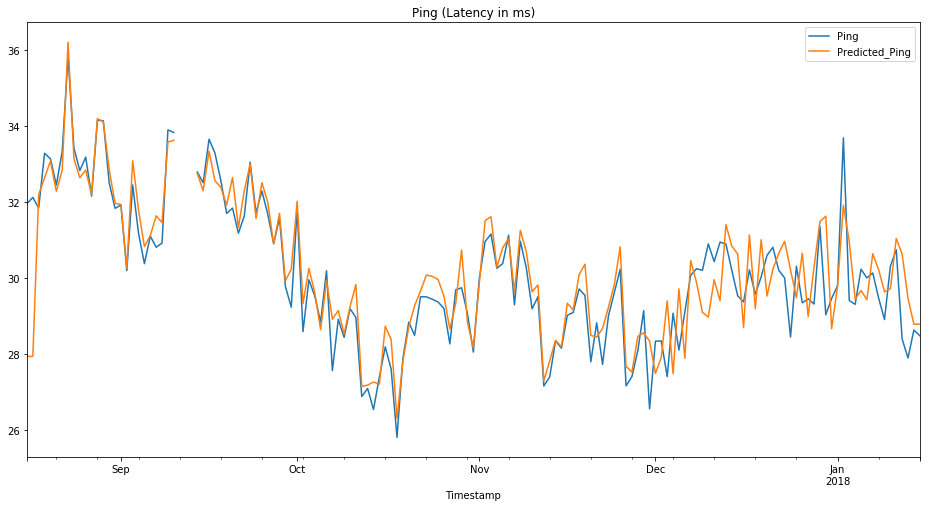

In [21]:
#data.drop(['Distance','Download','Upload'],axis=1).plot(figsize=(16,8),title='Ping (Latency in ms)')
data.resample(sample_rate).drop(['Distance','Download','Upload'],axis=1).plot(figsize=(16,8),title='Ping (Latency in ms)')

### EOF